<a href="https://colab.research.google.com/github/jaden-2/Assignment/blob/master/tensorassignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
import numpy as np
import tensorflow as tf
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.datasets import load_iris
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from keras.datasets import mnist


<h3>Problem 1</h3>
<p>Things I needed to implment for deep learing:</p>
<ol>
<li>I had to initilizew weights and baises</li>
<li>I have to perform initlize the nodes of each hidden layer of the network</li>
<li>I performed forward propagation for each layer</li>
<li>I had to implement an activation function and applied it on the output of each layer</li>
<li>I had to implement a loss function</li>
<li>I had to implement back propagaiton method for the network</li>
<li>I had to train the model using a fit  method</li>
<li>I had to implement an optimizer to update the values of weights and baises</li>
<li>I had to implement a predict method</li>
</ol>

<h3>Problem 2</h3>

<p>&emsp;The sample code is a deep learning logistic regression model implemented using tensor flow version 1. The model is trained to learn to distinguish between species of flowers, specifically iris flowers of the <b><i>versicolor and virginica </i></b> class.<br/>
&emsp; The sample code begins by performing feature selection and data processing on the iris dataset, followed by the definition of the mini batch class. Further down, the paramters for the layers in the class were initilized and assigned values. The exmaple_net function defines the forward propagation operation for the network. Loss_op, train_op, optimizer, and accuracy are used to calculate the loss, forward, backward propagation, and accuracy of the model respectively. <br/>
&emsp; TensorFlow version one by default using graph computation, therefore a session has to be created for the training of the model. This session was created using the tf.session method. Within this session, the model is trained.

</p>

In [18]:
class GetMiniBatch:
    """
Iterator to get a mini-batch

    Parameters
    ----------
    X : The following forms of ndarray, shape (n_samples, n_features)
      Training data
    y : The following form of ndarray, shape (n_samples, 1)
      Correct answer value
    batch_size : int
      Batch size
    seed : int
      NumPy random seed
    """
    def __init__(self, X, y, batch_size = 20, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int_)

    def __len__(self):
        return self._stop

    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1]

    def __iter__(self):
        self._counter = 0
        return self

    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]

In [19]:
iris = load_iris()
features = iris["data"]
target = iris["target"]

x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.2)

x_train, y_train, x_test, y_test = x_train.astype(np.float32), y_train.astype(np.float32), x_test.astype(np.float32), y_test.astype(np.float32)
y_train = y_train.reshape(-1, 1)
onv = OneHotEncoder(sparse_output=False)
y_train = onv.fit_transform(y_train)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2)


<h3>Problem 3</h3>

In [20]:


# network parameters


class Layer(tf.Module):
    def __init__(self, n_input, n_output, activation=None, name=None):
        super().__init__(name=name)
        self.weight = tf.Variable(tf.random.normal([n_input, n_output]))
        self.bais = tf.Variable(tf.random.normal([n_output]))
        self.activation = activation

    def __call__(self, x):
        y = tf.add(tf.matmul(x, self.weight), self.bais)
        if self.activation == None:
            return y
        return self.activation(y)


class LogisticRegression:
    def __init__(self, n_input = 4, n_classes=3,  lr=0.01, epoch=100, batch_size = 20):
        self.lr = lr
        self.epoch = epoch
        self.batch = batch_size
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=self.lr)
        self.inputlayer = Layer(n_input, 100, tf.nn.relu, "InputLayer")
        self.hidden1 = Layer(100, 50, tf.nn.relu, "hidden1")
        self.output = Layer(50,n_classes , name="outputLayer")

    #@tf.function
    def forward(self, x):
        logit = self.inputlayer(x)
        logit = self.hidden1(logit)
        logit = self.output(logit)

        return logit

    def fit(self, x_train, y_train, x_val=None, y_val=None):
        if x_val is None:
            x_val = x_train
            y_val = y_train
        for i in range(self.epoch):
            total_loss = 0
            for mini_x, mini_y in GetMiniBatch(x_train, y_train, self.batch):
                with tf.GradientTape() as tape:
                    logit = self.forward(mini_x)
                    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(mini_y, logit))

                gradient = tape.gradient(loss, tape.watched_variables())
                self.optimizer.apply_gradients(zip(gradient, tape.watched_variables()))
                total_loss+= loss
            total_loss/=self.batch

            with tf.GradientTape() as tape:
                logit = self.forward(x_val)
                loss_val = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(y_val, logit))
            accuracy = accuracy_score(np.argmax(y_train, 1), self.predict(x_train))
            gradient = tape.gradient(loss_val, tape.watched_variables())
            self.optimizer.apply_gradients(zip(gradient, tape.watched_variables()))

            print(f"Num epoch: {i} loss: {total_loss}: loss_val: {loss_val} accuracy: {accuracy}")
        return self

    def predict(self, x):
        y = tf.nn.softmax(self.forward(x)).numpy()

        return np.argmax(y, 1)


def accuracy_score(y_true, pred):
    correct = np.sum(np.round(y_true) == np.round(pred))
    total = y_true.shape[0]
    return correct/total



In [21]:
model = LogisticRegression()
model.fit(x_train, y_train, x_val, y_val)

Num epoch: 0 loss: 21.597835540771484: loss_val: 18.280704498291016 accuracy: 0.6979166666666666
Num epoch: 1 loss: 5.388648509979248: loss_val: 2.204501152038574 accuracy: 0.78125
Num epoch: 2 loss: 2.791081190109253: loss_val: 1.6895052194595337 accuracy: 0.8541666666666666
Num epoch: 3 loss: 0.7661638259887695: loss_val: 1.7485237121582031 accuracy: 0.8645833333333334
Num epoch: 4 loss: 0.293768972158432: loss_val: 1.8758119344711304 accuracy: 0.875
Num epoch: 5 loss: 0.11983370780944824: loss_val: 0.14640755951404572 accuracy: 0.9479166666666666
Num epoch: 6 loss: 0.10248859226703644: loss_val: 0.8635269999504089 accuracy: 0.8958333333333334
Num epoch: 7 loss: 0.07533581554889679: loss_val: 0.1449752300977707 accuracy: 0.9583333333333334
Num epoch: 8 loss: 0.07736452668905258: loss_val: 0.8932039737701416 accuracy: 0.90625
Num epoch: 9 loss: 0.0696650892496109: loss_val: 0.23529575765132904 accuracy: 0.9583333333333334
Num epoch: 10 loss: 0.07337808609008789: loss_val: 0.9098072052

In [22]:
pred = model.predict(x_test)

accuracy_score(y_test, pred)

1.0

Text(0, 0.5, 'True value')

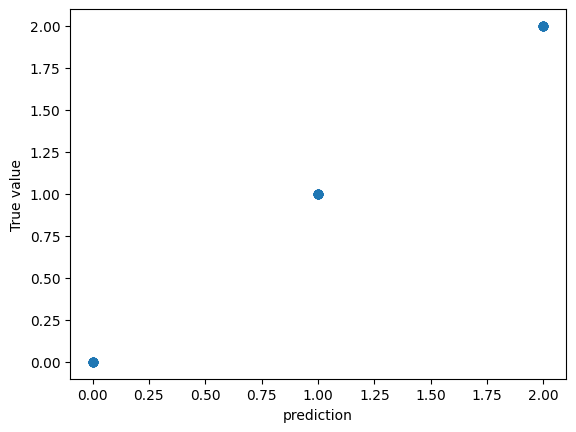

In [23]:
plt.scatter(pred, y_test)
plt.xlabel("prediction")
plt.ylabel("True value")

<h3>Problem 4</h3>

In [24]:
house_train = pd.read_csv("/content/train.csv")

<Axes: ylabel='SalePrice'>

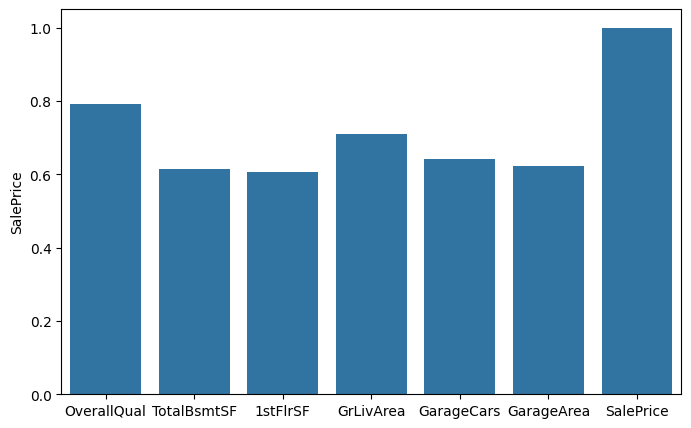

In [25]:
import seaborn as sns

test = house_train.dropna(axis=1).corr(numeric_only=True)
test = test["SalePrice"]
test = test[test > 0.6]

plt.figure(figsize=(8, 5))
sns.barplot(test)

In [26]:
def standardScaler(x):# standardization
    num = x - np.mean(x)
    return num/np.std(x)

def normalization(x):
    num = x - np.min(x)
    denum = np.max(x) - np.min(x)
    return num/denum

features = ["OverallQual","GrLivArea", "YearBuilt"]
target = ["SalePrice"]

y = house_train[target]
x = house_train[features]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

# standardization of data
#x_train = x.apply(standardScaler).to_numpy().astype(np.float32)
#y_train = y.apply(standardScaler).to_numpy().astype(np.float32)

x_train = x.to_numpy().astype(np.float32)
y_train = y.to_numpy().astype(np.float32)

# normalization
# x_train = x.apply(normalization).to_numpy().astype(np.float32)
# y_train = y.apply(normalization).to_numpy().astype(np.float32)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2)

x_test, y_test = x_test.to_numpy().astype(np.float32), y_test.to_numpy().astype(np.float32)

In [27]:
class LinearRegression:
    def __init__(self, n_input=3, lr=0.001, epoch= 100, batch_size=20):
        self.lr = lr
        self.batch_size = batch_size
        self.epoch = epoch
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=self.lr)
        self.inputLayer = Layer(n_input, 200, name= "inputLayer")
        self.middleLayer1 = Layer(200, 100, name="middleLayer")
        self.middleLayer = Layer(100, 50, name="middleLayer")
        self.outputLayer = Layer(50, 1, name="outputLayer")
        self.loss = np.array([])

    def forward(self, x):
        logit = self.inputLayer(x)
        logit = self.middleLayer1(logit)
        logit = self.middleLayer(logit)
        logit = self.outputLayer(logit)

        return logit

    def predict(self, x):
        return self.forward(x)

    def fit(self, x_train, y_train, x_val=None, y_val=None):
        if x_val is None:
            x_val = x_train
            y_val = y_train

        for i in range(self.epoch):
            totalLoss = 0
            for mini_x, mini_y in GetMiniBatch(x_train, y_train, batch_size= self.batch_size):
                with tf.GradientTape() as tape:
                    y = self.forward(mini_x)
                    #MSE loss function
                    loss = tf.reduce_mean(tf.pow(y - mini_y, 2))
                    totalLoss += loss

                gradient = tape.gradient(loss, tape.watched_variables())
                self.optimizer.apply_gradients(zip(gradient, tape.watched_variables()))

            totalLoss/=self.batch_size
            self.loss = np.append(self.loss, totalLoss)

            with tf.GradientTape() as tape:
                y = self.forward(x_val)

                loss_val = tf.reduce_mean(tf.pow(y-y_val, 2))

            gradient = tape.gradient(loss_val, y)

            self.optimizer.apply_gradients(zip(gradient, tape.watched_variables()))
            accuracy = accuracy_score(y_val, self.predict(x_val))

            print(f"Epoch: {i} loss: {totalLoss} Loss_val: {loss_val}")

        return self








In [28]:
linearModel = LinearRegression(epoch=100, lr=1e-5)

linearModel.fit(x_train, y_train, x_val, y_val)

Epoch: 0 loss: 11492017569792.0 Loss_val: 3471315042304.0
Epoch: 1 loss: 9304560107520.0 Loss_val: 2790485655552.0
Epoch: 2 loss: 7465355182080.0 Loss_val: 2221414547456.0
Epoch: 3 loss: 5936969154560.0 Loss_val: 1751714103296.0
Epoch: 4 loss: 4683109236736.0 Loss_val: 1369154519040.0
Epoch: 5 loss: 3668482195456.0 Loss_val: 1061996593152.0
Epoch: 6 loss: 2859353243648.0 Loss_val: 819104907264.0
Epoch: 7 loss: 2223990112256.0 Loss_val: 630107275264.0
Epoch: 8 loss: 1733066096640.0 Loss_val: 485487575040.0
Epoch: 9 loss: 1359927705600.0 Loss_val: 376690573312.0
Epoch: 10 loss: 1080860409856.0 Loss_val: 296189231104.0
Epoch: 11 loss: 875265720320.0 Loss_val: 237533904896.0
Epoch: 12 loss: 725719252992.0 Loss_val: 195338977280.0
Epoch: 13 loss: 617880027136.0 Loss_val: 165240815616.0
Epoch: 14 loss: 540297297920.0 Loss_val: 143805448192.0
Epoch: 15 loss: 484099227648.0 Loss_val: 128416317440.0
Epoch: 16 loss: 442634141696.0 Loss_val: 117141020672.0
Epoch: 17 loss: 411067744256.0 Loss_val:

Text(0, 0.5, 'true value')

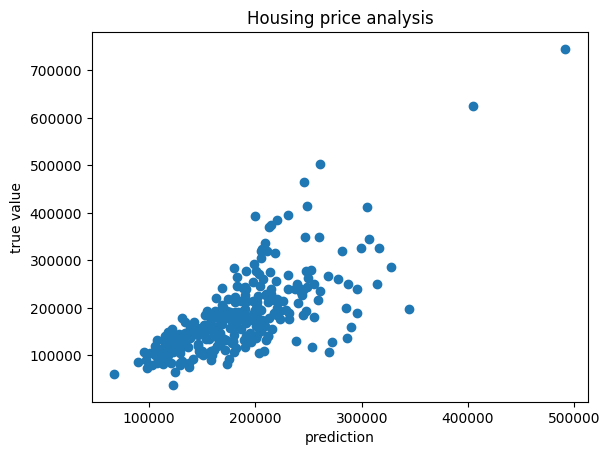

In [29]:
pred = linearModel.predict(x_test)

plt.scatter(pred, y_test)
plt.title("Housing price analysis")
plt.xlabel("prediction")
plt.ylabel("true value")

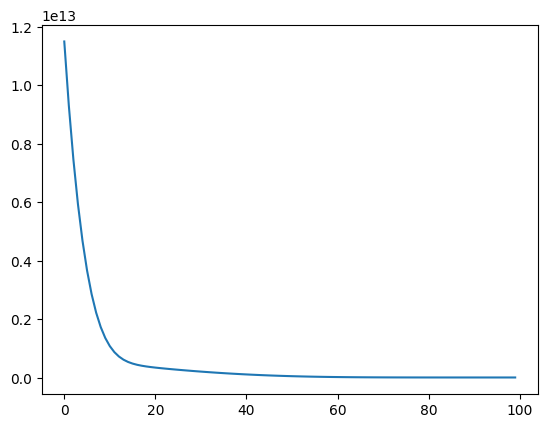

In [30]:
plt.plot(linearModel.loss)

<p>
The difference between a classification and regression problem is in the use of activation functions. In a linear regression problem, the model tries to fit the data into a straight line, an activation function is not required. However, in a classification problem an activation function is required to output into probability distribution which is used to determine the class of a dataset.
</p>




<h3>Problem 5</h3>

In [31]:
class DeepNeuralNetwork:
    def __init__(self, n_input = 4, n_classes=3,  lr=0.01, epoch=100, batch_size = 20):
        self.lr = lr
        self.epoch = epoch
        self.batch = batch_size
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=self.lr)
        self.inputlayer = Layer(n_input, 400, tf.nn.relu, "InputLayer")
        self.hidden1 = Layer(400, 200, tf.nn.relu, "hidden1")
        self.output = Layer(200, n_classes, name="outputLayer")

    #@tf.function
    def forward(self, x):
        logit = self.inputlayer(x)
        logit = self.hidden1(logit)
        logit = self.output(logit)

        return logit

    def fit(self, x_train, y_train, x_val=None, y_val=None):
        if x_val is None:
            x_val = x_train
            y_val = y_train
        for i in range(self.epoch):
            total_loss = 0
            for mini_x, mini_y in GetMiniBatch(x_train, y_train, self.batch):
                with tf.GradientTape() as tape:
                    logit = self.forward(mini_x)
                    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(mini_y, logit))

                gradient = tape.gradient(loss, tape.watched_variables())
                self.optimizer.apply_gradients(zip(gradient, tape.watched_variables()))
                total_loss+= loss
            total_loss/=self.batch

            with tf.GradientTape() as tape:
                logit = self.forward(x_val)
                loss_val = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(y_val, logit))
            accuracy = accuracy_score(np.argmax(y_train, 1), self.predict(x_train))
            gradient = tape.gradient(loss_val, tape.watched_variables())
            self.optimizer.apply_gradients(zip(gradient, tape.watched_variables()))

            print(f"Num epoch: {i} loss: {total_loss}: loss_val: {loss_val} accuracy: {accuracy}")
        return self

    def predict(self, x):
        y = tf.nn.softmax(self.forward(x)).numpy()

        return np.argmax(y, 1)


def accuracy_score(y_true, pred):
    correct = np.sum(np.round(y_true) == np.round(pred))
    total = y_true.shape[0]
    return correct/total

In [43]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
y_train, y_test = y_train.reshape(-1, 1), y_test.reshape(-1, 1)
x_train, x_test = x_train.reshape(-1, 784).astype(np.float32), x_test.reshape(-1, 784).astype(np.float32)

x_train /= 255
x_test /= 255

y_train = onv.fit_transform(y_train)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2)

In [33]:
x_train.shape
#y_train.shape
n_input = x_train.shape[1]
n_classes = y_train.shape[1]

In [34]:
model = DeepNeuralNetwork(lr=0.001, n_input=n_input, n_classes=n_classes, epoch=10).fit(x_train, y_train, x_val, y_val)

Num epoch: 0 loss: 11395.6142578125: loss_val: 37.25117111206055 accuracy: 0.9132916666666666
Num epoch: 1 loss: 2703.834228515625: loss_val: 24.505062103271484 accuracy: 0.9467708333333333
Num epoch: 2 loss: 1412.4647216796875: loss_val: 20.322420120239258 accuracy: 0.95925
Num epoch: 3 loss: 782.0758056640625: loss_val: 18.732431411743164 accuracy: 0.9658958333333333
Num epoch: 4 loss: 505.71710205078125: loss_val: 16.69442367553711 accuracy: 0.9701041666666667
Num epoch: 5 loss: 351.2389221191406: loss_val: 15.478032112121582 accuracy: 0.9795416666666666
Num epoch: 6 loss: 269.8404846191406: loss_val: 14.831217765808105 accuracy: 0.9851458333333334
Num epoch: 7 loss: 209.45187377929688: loss_val: 13.600619316101074 accuracy: 0.9871458333333333
Num epoch: 8 loss: 162.71311950683594: loss_val: 13.610244750976562 accuracy: 0.9862083333333334
Num epoch: 9 loss: 149.6765899658203: loss_val: 12.473906517028809 accuracy: 0.9895625


In [46]:
pred = model.predict(x_test)



In [51]:
print(pred.shape)
y_test.shape


(10000,)


(10000, 1)

In [48]:
from sklearn.metrics import confusion_matrix, accuracy_score

confusion_matrix(y_test, pred)

array([[ 968,    1,    0,    2,    0,    5,    2,    1,    0,    1],
       [   0, 1108,    4,    3,    3,    3,    4,    1,    6,    3],
       [   5,    3,  974,   17,    4,    3,    7,    7,   11,    1],
       [   0,    0,    7,  963,    1,   20,    0,    5,    4,   10],
       [   0,    0,    0,    0,  947,    2,    9,    5,    3,   16],
       [   4,    0,    0,   13,    2,  856,    4,    1,    6,    6],
       [   7,    2,    0,    1,    5,   11,  926,    1,    4,    1],
       [   1,    5,    9,    6,   12,    2,    0,  968,    6,   19],
       [   0,    2,    5,   19,    8,   19,    2,    5,  904,   10],
       [   3,    2,    0,   10,   27,    2,    0,   11,    9,  945]])

In [49]:
accuracy_score(y_test, pred)


0.9559